In [1]:
import pandas as pd
import numpy as np

In [2]:
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string) # engine keeps the connection with DB alive until close connection

###### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [4]:
# Where are goint to extract all the information we think can explain the number of rentals

query = '''SELECT f.film_id, f.title, f.rental_rate,f.length,f.rating, c.name, q.times_rented_in_2005
FROM sakila.film f
JOIN sakila.film_category fc
ON f.film_id = fc.film_id
JOIN sakila.category c
ON fc.category_id = c.category_id
JOIN (SELECT i.film_id, count(r.inventory_id) AS times_rented_in_2005
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
WHERE r.rental_date between "2005-01-01 00:00:00" and "2005-12-31 23:59:00"
GROUP BY i.film_id
ORDER BY i.film_id ASC) q
ON q.film_id = f.film_id
ORDER BY f.film_id;'''

data = pd.read_sql_query(query, engine)

data

# This data include all the movies rented in 2005 and the number of times rented in the year

,film_id,title,rental_rate,length,rating,name,times_rented_in_2005
0,1,ACADEMY DINOSAUR,0.99,86,PG,Documentary,23
1,2,ACE GOLDFINGER,4.99,48,G,Horror,6
2,3,ADAPTATION HOLES,2.99,50,NC-17,Documentary,12
3,4,AFFAIR PREJUDICE,2.99,117,G,Horror,22
4,5,AFRICAN EGG,2.99,130,G,Family,11
...,...,...,...,...,...,...,...
953,996,YOUNG LANGUAGE,0.99,183,G,Documentary,7
954,997,YOUTH KICK,0.99,179,NC-17,Music,6
955,998,ZHIVAGO CORE,0.99,105,NC-17,Horror,8
956,999,ZOOLANDER FICTION,2.99,101,R,Children,17


##### Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [5]:
# Movies rented in May 2005

query1 = '''SELECT i.film_id
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
WHERE r.rental_date between "2005-05-01 00:00:00" and "2005-05-31 23:59:00"
GROUP BY i.film_id
ORDER BY i.film_id ASC;'''

data1 = pd.read_sql_query(query1, engine)

data1.head()


,film_id
0,1
1,3
2,4
3,5
4,6


In [6]:
len(data1['film_id']) # We had 686 movies rented in may

data1['film_id'].unique() # This is an array with all the films_id rented in May 2005

array([   1,    3,    4,    5,    6,    8,   11,   12,   15,   16,   17,
         18,   19,   21,   23,   25,   26,   28,   29,   30,   31,   34,
         39,   40,   42,   43,   45,   46,   47,   48,   50,   51,   52,
         54,   55,   56,   57,   58,   59,   60,   61,   63,   65,   67,
         68,   70,   71,   73,   75,   77,   78,   79,   80,   81,   82,
         83,   84,   85,   86,   89,   90,   93,   95,   96,   97,   98,
        100,  101,  103,  104,  109,  110,  111,  112,  113,  114,  115,
        116,  117,  119,  120,  126,  127,  129,  130,  131,  132,  134,
        135,  137,  138,  139,  140,  141,  142,  143,  145,  147,  149,
        150,  151,  152,  154,  155,  156,  158,  159,  160,  162,  164,
        166,  167,  169,  172,  173,  174,  176,  177,  178,  179,  181,
        182,  184,  186,  187,  190,  191,  196,  197,  200,  201,  202,
        203,  204,  205,  206,  208,  209,  210,  211,  212,  213,  215,
        216,  218,  219,  220,  226,  227,  228,  2

In [7]:
cols = [] # We create a list

for m in data['film_id']: # For each value in column
    if m in data1['film_id'].unique(): # if the value is in the previous array 
        cols.append('Yes') 
    else:
        cols.append('No')
cols

# Now we can create the new bolean column in data 

data['rented_in_may']=cols

data['rented_in_may'].value_counts()

# for m in data['film_id']: # For each value in column
#     if m in data1['film_id'] # This adds 686 yes and 272 noes as well but firts all the yes and after all the noes 
#         cols.append('Yes') 
#     else:
#         cols.append('No')

Yes    686
No     272
Name: rented_in_may, dtype: int64

In [8]:
data.head()

,film_id,title,rental_rate,length,rating,name,times_rented_in_2005,rented_in_may
0,1,ACADEMY DINOSAUR,0.99,86,PG,Documentary,23,Yes
1,2,ACE GOLDFINGER,4.99,48,G,Horror,6,No
2,3,ADAPTATION HOLES,2.99,50,NC-17,Documentary,12,Yes
3,4,AFFAIR PREJUDICE,2.99,117,G,Horror,22,Yes
4,5,AFRICAN EGG,2.99,130,G,Family,11,Yes


##### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [9]:
data.isna().sum() # No NaN values
data['rental_rate'].unique()
data['length'].unique()
data['rating'].unique()
data['name'].unique()
# No extrange values within each column

array(['Documentary', 'Horror', 'Family', 'Foreign', 'Comedy', 'Sports',
       'Music', 'Animation', 'Action', 'New', 'Sci-Fi', 'Classics',
       'Games', 'Children', 'Travel', 'Drama'], dtype=object)

In [11]:
data=data.drop(['times_rented_in_2005'], axis=1)

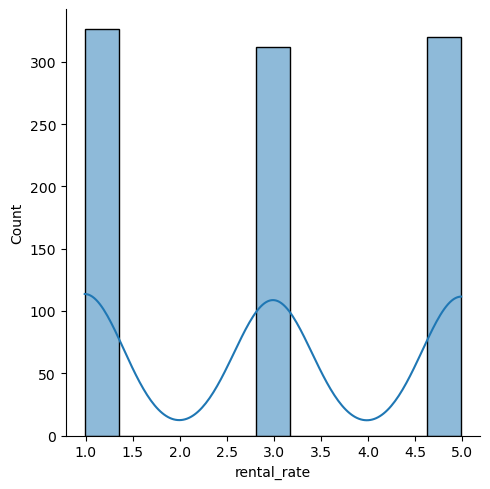

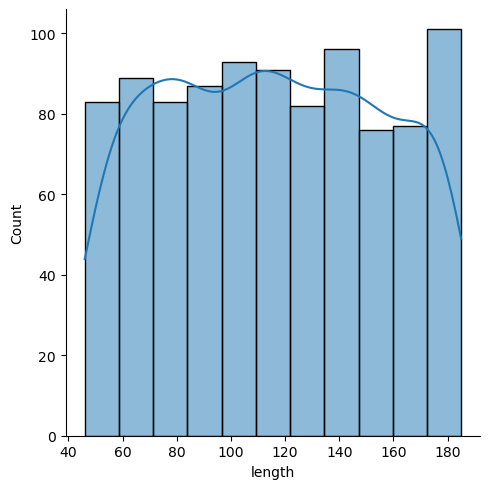

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data['rental_rate'], kde = True)
plt.show()

sns.displot(data['length'], kde = True)
plt.show()



In [13]:
correlation_matrix = data.corr()
correlation_matrix = correlation_matrix.round(2)
display(correlation_matrix)

,film_id,rental_rate,length
film_id,1.00,-0.03,0.05
rental_rate,-0.03,1.00,0.04
length,0.05,0.04,1.00


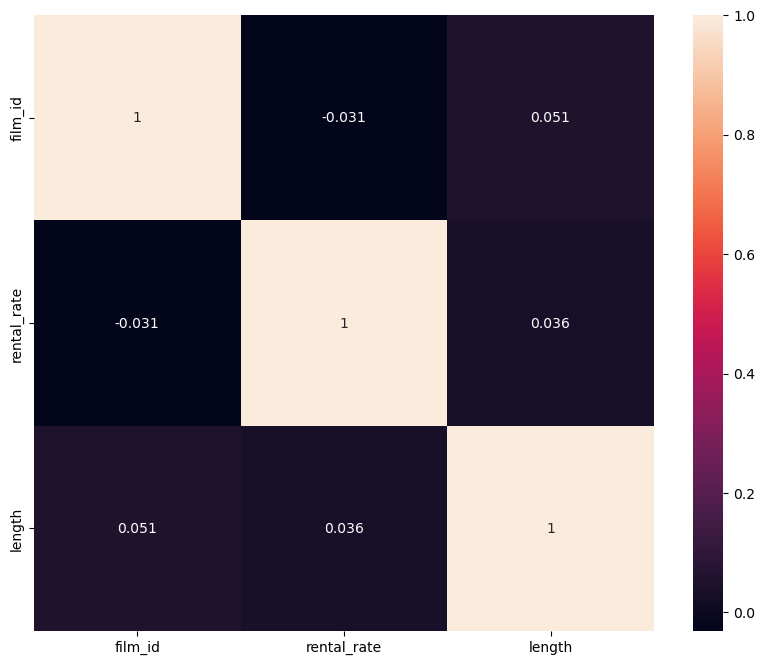

In [14]:
corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
data = data.drop(['film_id','title'], axis = 1)

In [16]:
# Split into y and X
y = data['rented_in_may']
X = data.drop(['rented_in_may'], axis = 1)

In [17]:
# Create groups for numerical and categorical
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object) 

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_num.columns)
X_train_norm

,rental_rate,length
0,0.0,0.410072
1,0.0,0.050360
2,0.5,0.201439
3,0.5,0.956835
4,0.0,0.546763
...,...,...
761,1.0,0.913669
762,0.0,0.935252
763,1.0,0.762590
764,0.0,0.431655


In [22]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'name'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
102,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
515,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
133,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [24]:
X_train_transformed

array([[0.        , 0.41007194, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05035971, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.20143885, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.76258993, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.43165468, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.35251799, 0.        , ..., 0.        , 0.        ,
        0.        ]])

##### Create a logistic regression model to predict this variable from the cleaned data.

In [25]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [26]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [27]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [29]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'name'],
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# not needed if you treat each dataframe with one_hot_encoder and save the encode (and the column names)

X_test_cat.head()

[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('name_Animation', 'name_Animation'),
 ('name_Children', 'name_Children'),
 ('name_Classics', 'name_Classics'),
 ('name_Comedy', 'name_Comedy'),
 ('name_Documentary', 'name_Documentary'),
 ('name_Drama', 'name_Drama'),
 ('name_Family', 'name_Family'),
 ('name_Foreign', 'name_Foreign'),
 ('name_Games', 'name_Games'),
 ('name_Horror', 'name_Horror'),
 ('name_Music', 'name_Music'),
 ('name_New', 'name_New'),
 ('name_Sci-Fi', 'name_Sci-Fi'),
 ('name_Sports', 'name_Sports'),
 ('name_Travel', 'name_Travel')]

,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
662,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
401,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
876,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
889,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
349,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [31]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.734375

In [32]:
print(y_test.value_counts())


Yes    141
No      51
Name: rented_in_may, dtype: int64


In [33]:
pd.Series(predictions).value_counts()
# This shows that the disparity in the numbers are amplified by the model

Yes    192
dtype: int64

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions) 


array([[  0,  51],
       [  0, 141]])